In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

c:\Users\Loassar\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = r'src\dataset\russian_comments_from_2ch_pikabu.csv'
df = pd.read_csv(path)
df = df.drop(columns='translated')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [4]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [5]:
def get_sample_data(df, n_samples=1500):
    # Стратифицированная выборка
    df_sampled = resample(
        df,
        replace=False,  # Без замены
        n_samples=n_samples,  # Количество выборки
        stratify=df["toxic"],  # Указываем метки
        random_state=42  # Для воспроизводимости
    )
    return df_sampled

df_cat = get_sample_data(df, n_samples=3000)

In [6]:
X = df_cat['comment']
y = df_cat['toxic']
X_part = X.to_numpy()
y_part = y.to_numpy().reshape(-1,1)

In [7]:
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

base_model.eval()
MAX_LENGTH = 128

In [8]:
def filter_and_tokenize(X, y, tokenizer, max_length=MAX_LENGTH):
    """
    Функция отфильтровывает слишком длинные предложения
    (более max_length токенов), затем возвращает
    отфильтрованный X, y и токенизированные входные данные.
    """
    X_filtered = []
    y_filtered = []

    for text, label in zip(X, y):
        # Токенизация "на лету", чтобы понять, сколько токенов получится
        tokens = tokenizer.tokenize(text)
        if len(tokens) <= max_length:
            X_filtered.append(text)
            y_filtered.append(label)

    # Теперь делаем окончательную токенизацию для всей выборки
    encoded = tokenizer(
        X_filtered,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"  # сразу вернёт PyTorch тензоры
    )
    print("Special tokens:", tokenizer.special_tokens_map)
    return X_filtered, y_filtered, encoded

In [9]:
print("Hidden size (original):", base_model.config.hidden_size)  # Обычно 312 для rubert-tiny2
# Обёрточный класс, возвращающий эмбеддинги как есть (без проекции)
class Embedder(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, input_ids, attention_mask=None):
        # Получаем скрытые состояния
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        # outputs.last_hidden_state.shape = [batch_size, seq_len, hidden_size=312]

        # 1) Если нужен [CLS]-эмбеддинг (один вектор на предложение), берём первый токен
        # cls_embeddings = outputs.last_hidden_state[:, 0, :]

        # 2) Если нужно получить эмбеддинги для всех токенов, используем:
        all_embeddings = outputs.last_hidden_state
        # return all_embeddings

        return all_embeddings

Hidden size (original): 312


In [10]:
# Инициализация "чистой" модели-эмбеддера
X_tkn, y_tkn, encoded_data = filter_and_tokenize(X_part, y_part, tokenizer=tokenizer, max_length=MAX_LENGTH)
embedder = Embedder(base_model=base_model)
embedder.eval()

# Генерация эмбеддингов
with torch.no_grad():
    embeddings = embedder(
        input_ids=encoded_data["input_ids"],
        attention_mask=encoded_data["attention_mask"]
    )

print("Форма эмбеддингов [CLS]:", embeddings.shape)

Special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
Форма эмбеддингов [CLS]: torch.Size([2850, 128, 312])


In [11]:
emb_size = embeddings.numpy().shape[-1]
y_tkn = np.array(y_tkn)
X_tkn = np.array(X_tkn)
X_train, X_test, y_train, y_test = train_test_split(embeddings.numpy(), y_tkn, test_size=0.3,  random_state=42, stratify=y_tkn)

In [12]:
def create_batches(X: np.ndarray, y: np.ndarray, batch_size: int = 32, shuffle: bool = False):
    num_samples = X.shape[0]

    if shuffle:
        # Генерируем случайные индексы для перемешивания данных
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]

    # Рассчитываем количество батчей
    num_batches = int(np.ceil(num_samples / batch_size))

    batches = []
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, num_samples)
        X_batch = X[start_idx:end_idx]
        y_batch = y[start_idx:end_idx]
        batches.append((X_batch, y_batch))

    return batches

batches = create_batches(X_train, y_train, batch_size=150)

In [13]:
from src.layers.dense import Dense
from src.layers.transformer import Transformer
from src.activations import Sigmoid
from src.models import Sequential
from src.losses import BinaryCrossEntropy

model = Sequential(
    Transformer(heads=2, emb_size=emb_size),
    Dense(units=1, activation=Sigmoid())
)

model.fit(X_train, y_train, batches=batches, loss_function=BinaryCrossEntropy(), epochs=15, learning_rate=2e-4)

Epoch 1/15:   0%|          | 0/14 [00:00<?, ?batch/s]

Epoch 1/15: 100%|██████████| 14/14 [00:26<00:00,  1.86s/batch, Loss=0.462]


Epoch 1/15 | Loss: 0.674118


Epoch 2/15: 100%|██████████| 14/14 [00:25<00:00,  1.83s/batch, Loss=0.319]


Epoch 2/15 | Loss: 0.419296


Epoch 3/15: 100%|██████████| 14/14 [00:25<00:00,  1.80s/batch, Loss=0.301]


Epoch 3/15 | Loss: 0.333224


Epoch 4/15: 100%|██████████| 14/14 [00:25<00:00,  1.83s/batch, Loss=0.304]


Epoch 4/15 | Loss: 0.307085


Epoch 5/15: 100%|██████████| 14/14 [00:25<00:00,  1.84s/batch, Loss=0.294]


Epoch 5/15 | Loss: 0.292087


Epoch 6/15: 100%|██████████| 14/14 [00:25<00:00,  1.82s/batch, Loss=0.29] 


Epoch 6/15 | Loss: 0.279273


Epoch 7/15: 100%|██████████| 14/14 [00:26<00:00,  1.86s/batch, Loss=0.289]


Epoch 7/15 | Loss: 0.269427


Epoch 8/15: 100%|██████████| 14/14 [00:26<00:00,  1.87s/batch, Loss=0.289]


Epoch 8/15 | Loss: 0.261777


Epoch 9/15: 100%|██████████| 14/14 [00:26<00:00,  1.91s/batch, Loss=0.29] 


Epoch 9/15 | Loss: 0.255296


Epoch 10/15: 100%|██████████| 14/14 [00:26<00:00,  1.92s/batch, Loss=0.291]


Epoch 10/15 | Loss: 0.249486


Epoch 11/15: 100%|██████████| 14/14 [01:15<00:00,  5.38s/batch, Loss=0.292]


Epoch 11/15 | Loss: 0.244117


Epoch 12/15: 100%|██████████| 14/14 [01:21<00:00,  5.81s/batch, Loss=0.293]


Epoch 12/15 | Loss: 0.239036


Epoch 13/15: 100%|██████████| 14/14 [00:26<00:00,  1.87s/batch, Loss=0.293]


Epoch 13/15 | Loss: 0.234110


Epoch 14/15: 100%|██████████| 14/14 [00:26<00:00,  1.88s/batch, Loss=0.292]


Epoch 14/15 | Loss: 0.229229


Epoch 15/15: 100%|██████████| 14/14 [00:26<00:00,  1.91s/batch, Loss=0.291]

Epoch 15/15 | Loss: 0.224310


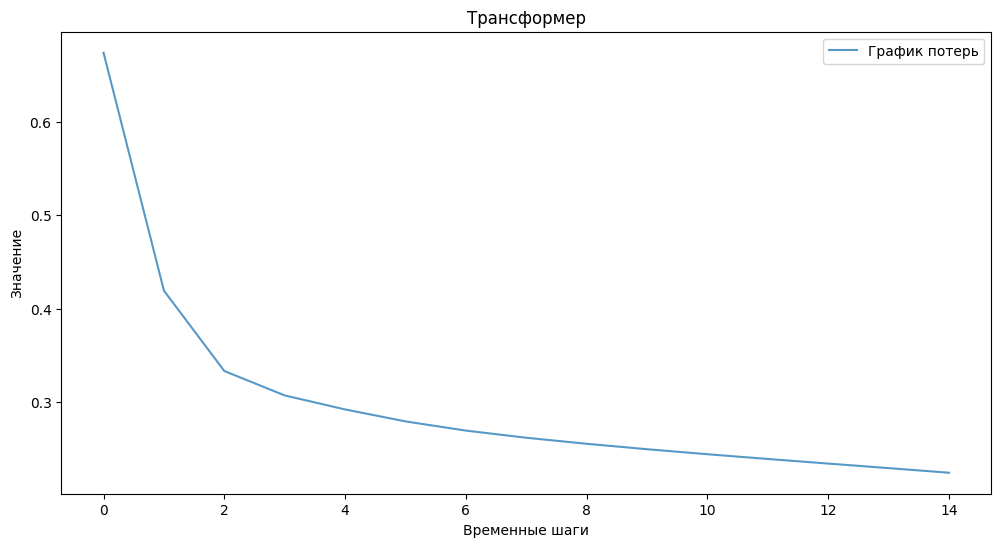

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(model.history['loss'], label="График потерь", alpha=0.75)
plt.title("Трансформер")
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.legend()
plt.show()

In [15]:
y_pred = model.predict(X_test)

In [16]:
y_pred = (y_pred > 0.5).astype(int)

In [17]:
from sklearn.metrics import classification_report, accuracy_score
# 3. Вычисление и вывод метрик
def print_metrics(y_true, y_pred, model_name):
    print(f"\nMetrics for model: {model_name}")
    print("-" * 40)
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, labels=(1, 0)))

# Вывод метрик
print_metrics(y_test, y_pred, "Transformer metrics")


Metrics for model: Transformer metrics
----------------------------------------
Accuracy: 0.8608
Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.89      0.81       289
           0       0.94      0.85      0.89       566

    accuracy                           0.86       855
   macro avg       0.84      0.87      0.85       855
weighted avg       0.87      0.86      0.86       855

